In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dtutil.sqltools import query_to_dataframe, get_cursor_from_url, list_to_query_list
import pylab
import datetime
pylab.rcParams['figure.figsize'] = (12,8)

In [3]:
df = pd.read_csv('/Users/dane/src/fitbit/data/apple_hr_data.csv')

In [4]:
df.head()

,source,datetime,hr
0,Watch,2017-11-01 13:36:26 -0800,67.0
1,Watch,2017-11-01 13:55:21 -0800,58.0
2,Watch,2017-11-01 14:00:40 -0800,82.0
3,Watch,2017-11-01 14:05:13 -0800,59.0
4,Watch,2017-11-01 14:08:32 -0800,61.0


In [7]:
df['datetime'] = pd.to_datetime(df.datetime)

In [8]:
df.head()

,source,datetime,hr
0,Watch,2017-11-01 21:36:26,67.0
1,Watch,2017-11-01 21:55:21,58.0
2,Watch,2017-11-01 22:00:40,82.0
3,Watch,2017-11-01 22:05:13,59.0
4,Watch,2017-11-01 22:08:32,61.0


In [9]:
df['bad'] = False
d = df.copy().set_index('datetime')

There are 2 distinct ranges of data here.  This is due to the loss of data when changing from one watch to another.  Let's split this data up.

In [30]:
df['day'] = df.datetime.apply(lambda x: x.strftime('%Y-%m-%d'))
df1 = df[df.datetime < datetime.datetime(2017,3,1)]
df2 = df[df.datetime > datetime.datetime(2017,3,1)]
print(len(df1))
print(len(df2))

75094
166261


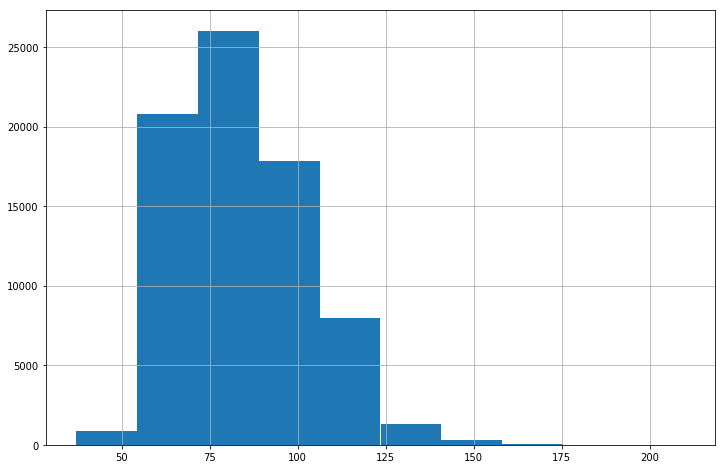

In [25]:
df1.hr.hist()

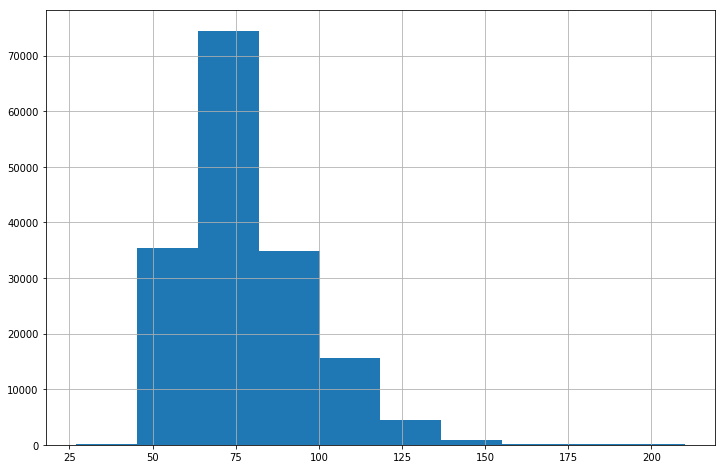

In [26]:
df2.hr.hist()

Looking at this data the histogram of df1 being more normal makes sense.  In df2, I have spent time deleting points I knew were bad and therefore I don't think it is a good indication of the distribution.  Let's look at some other metrics.

In [42]:
def days_over_x(df, x):
    all_days = len(df.day.unique())
    above_days = len(df[df.hr > x].day.unique())
    return above_days, all_days

In [47]:
days_over_x(df1, 150)

(19, 467)

In [46]:
days_over_x(df2, 150)

(29, 462)

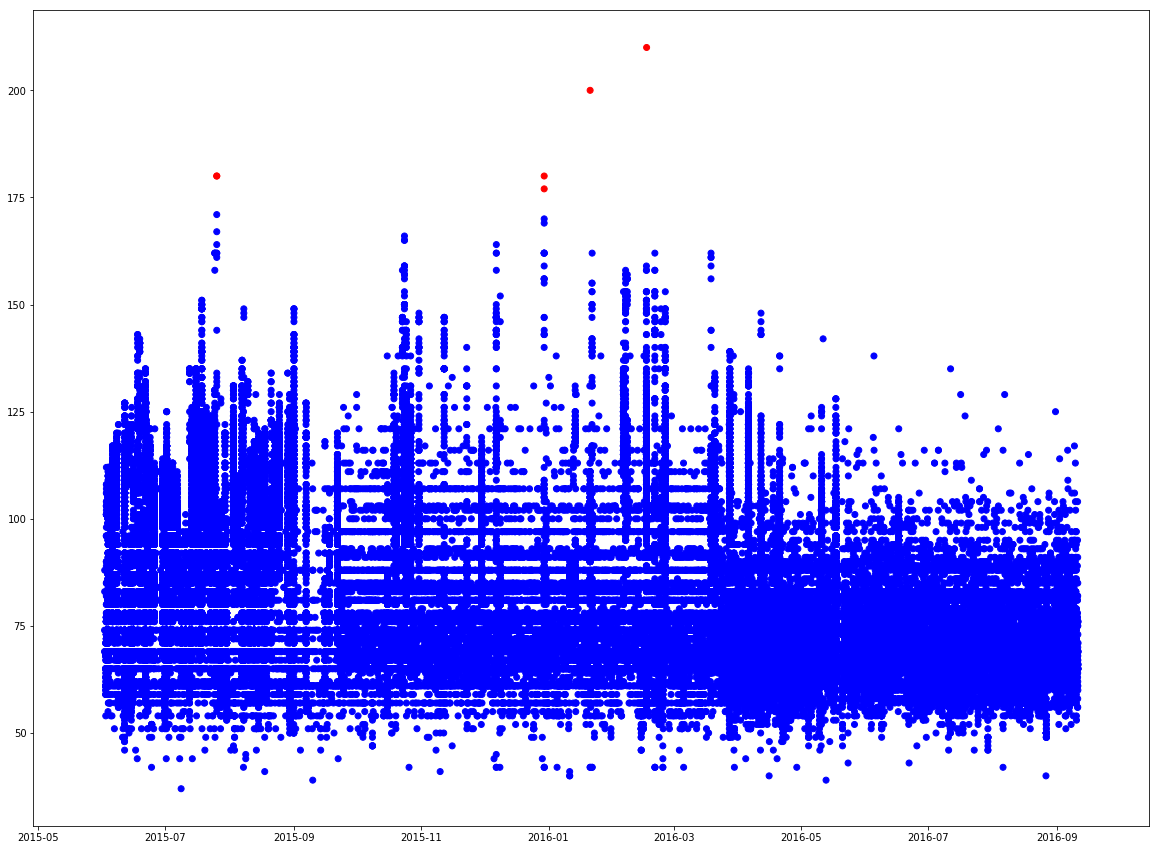

In [74]:
dd2 = df1.copy().set_index('datetime')
m1 = dd2.index > datetime.datetime(2015,7,1)
m2 = dd2.index <= datetime.datetime(2015,7,31)

dd2.loc[dd2.hr > 175, 'bad'] = True
dd2['color'] = 'blue'
dd2.loc[dd2.bad, 'color'] = 'red'

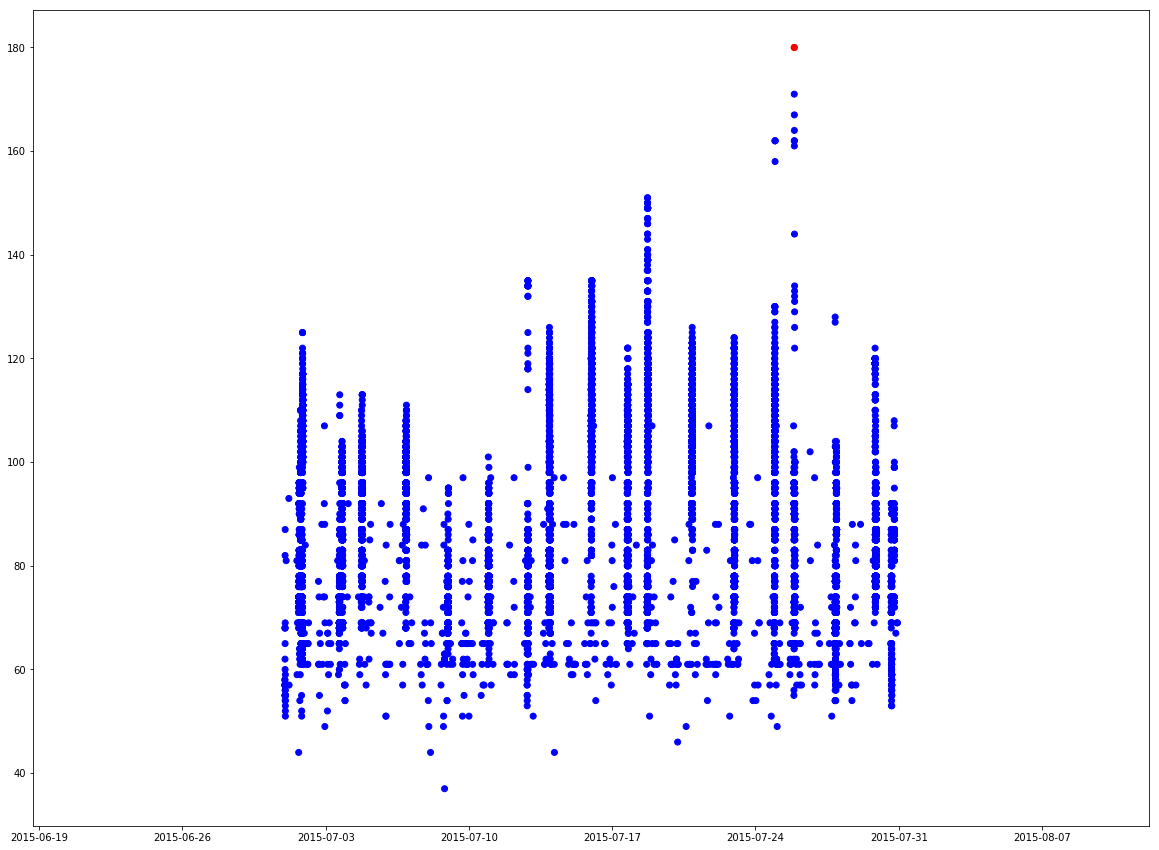

In [76]:
fig = plt.gcf()
fig.set_size_inches(20,15)
d = dd2[m1 & m2]
plt.scatter(d.index, d.hr, c=d.color)

In [184]:
def change_rate(r0, r1):
    delta_hr = abs(r1.hr - r0.hr)
    delta_time = max(r1.time - r0.time, 1)
    cr = delta_hr / delta_time
    # print(delta_hr, delta_time, cr)
    if delta_time > 300:
        return 0
    else:
        return cr


# implement a rate of change limit
m1 = dd2.index > datetime.datetime(2015,7,1)
m2 = dd2.index <= datetime.datetime(2015,7,21)
d = dd2[m1&m2].copy()
st = datetime.datetime(2015,6,1, 0, 0, 0, 0)
d['time'] = d.index
d['time'] = d.time.apply(lambda x: (x - st).total_seconds())

def crback(d):
    crlist = [0]
    d0 = None
    for idx, row in d.iterrows():
        if d0 is None:
            d0 = row
            continue
        cr = change_rate(d0, row)
        crlist.append(cr)
        d0 = row
    return crlist

d['cr_back'] = crback(d)

def crforward(d):
    crlist = []
    d0 = None
    for idx, row in d.iterrows():
        if d0 is None:
            d0 = row
            continue
        cr = change_rate(d0, row)
        crlist.append(cr)
        d0 = row
    crlist.append(0)
    return crlist
d['cr_forward'] = crforward(d)
d.head()

,source,hr,bad,day,color,time,cr_back,cr_forward
datetime,,,,,,,,
2015-07-01 00:05:06,Watch,58.0,False,2015-07-01,blue,2592306.0,0.000000,0.200000
2015-07-01 00:05:11,Watch,57.0,False,2015-07-01,blue,2592311.0,0.200000,0.000000
2015-07-01 00:05:16,Watch,57.0,False,2015-07-01,blue,2592316.0,0.000000,0.034483
2015-07-01 00:05:45,Watch,58.0,False,2015-07-01,blue,2592345.0,0.034483,0.200000
2015-07-01 00:05:50,Watch,57.0,False,2015-07-01,blue,2592350.0,0.200000,0.000000


In [185]:
d.head(50)

,source,hr,bad,day,color,time,cr_back,cr_forward
datetime,,,,,,,,
2015-07-01 00:05:06,Watch,58.0,False,2015-07-01,blue,2592306.0,0.000000,0.200000
2015-07-01 00:05:11,Watch,57.0,False,2015-07-01,blue,2592311.0,0.200000,0.000000
2015-07-01 00:05:16,Watch,57.0,False,2015-07-01,blue,2592316.0,0.000000,0.034483
2015-07-01 00:05:45,Watch,58.0,False,2015-07-01,blue,2592345.0,0.034483,0.200000
2015-07-01 00:05:50,Watch,57.0,False,2015-07-01,blue,2592350.0,0.200000,0.000000
2015-07-01 00:14:42,Watch,62.0,False,2015-07-01,blue,2592882.0,0.000000,0.083333
2015-07-01 00:15:54,Watch,68.0,False,2015-07-01,blue,2592954.0,0.083333,0.000000
2015-07-01 00:15:59,Watch,68.0,False,2015-07-01,blue,2592959.0,0.000000,0.000000
2015-07-01 00:16:04,Watch,68.0,False,2015-07-01,blue,2592964.0,0.000000,0.052632


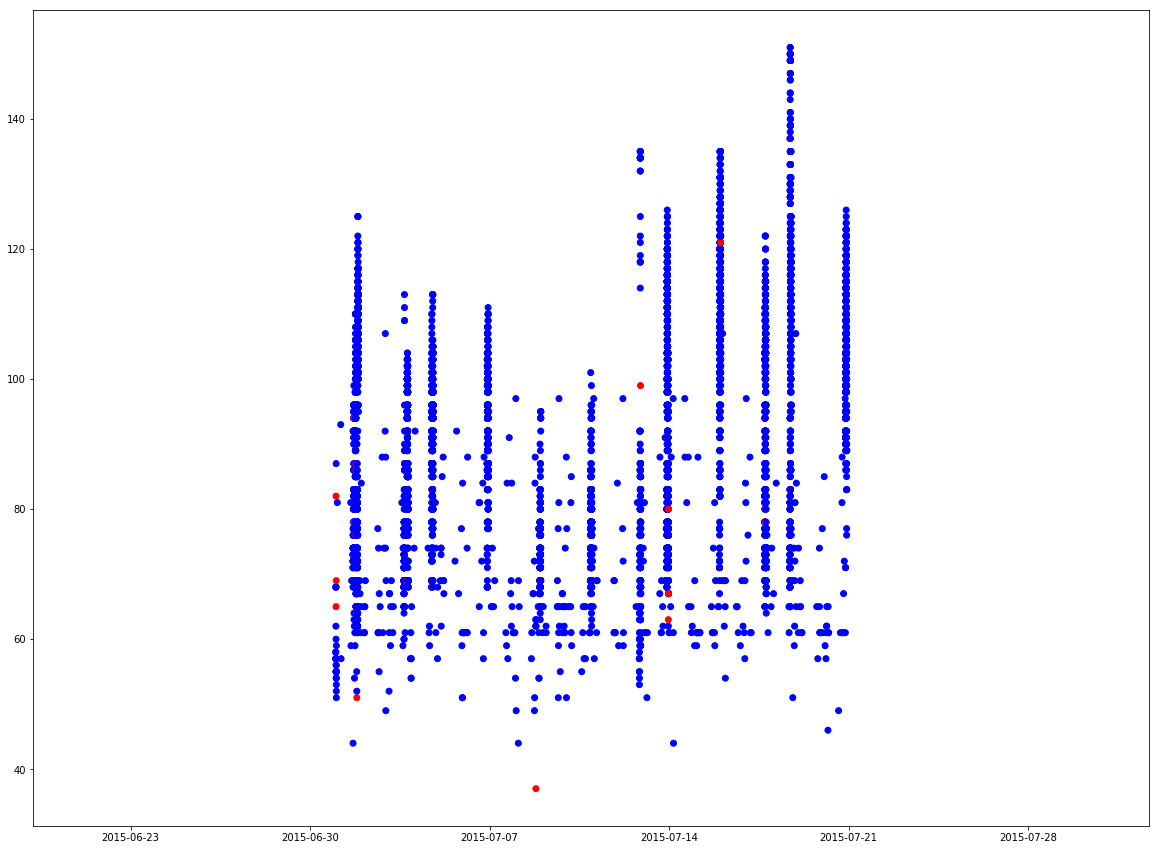

In [178]:
fig = plt.gcf()
fig.set_size_inches(20,15)
d['bad'] = crlist
d.loc[d.bad, 'color'] = 'red'
plt.scatter(d.index, d.hr, c=d.color)

plt.show()